### Trains Efficientnet architecture

In [1]:
import numpy as np
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
import keras

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K
%run helpers.py
import helpers # our helper script
from sklearn.model_selection import train_test_split

from efficientnet.keras import EfficientNetB0 # B0 or B5
from efficientnet.keras import center_crop_and_resize, preprocess_input


np.random.seed(1)

Using TensorFlow backend.


In [2]:
import tensorflow as tf

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [3]:
#Root directory of the project
ROOT_DIR = os.path.abspath(".")
DATASET_PATH = os.path.join(ROOT_DIR, "C:\All DataSet\leukomia")
VAL_DATASET_PATH = os.path.join(ROOT_DIR, "C:\All DataSet\leukomia")
LOG_PATH = os.path.join(ROOT_DIR, "C:\All DataSet\leukomia\LOG_PATH")
print(os.listdir(DATASET_PATH))
print(os.listdir(VAL_DATASET_PATH))
print(os.listdir(LOG_PATH))

['CycleGAN.PNG', 'Dataset', 'efficientnet_exp.ipynb', 'EXP_NAME', 'helpers.py', 'improving-cycle-gan-intel-ai-devcloud-fig10-780721.png', 'leuk-master', 'leuk-master.zip', 'Leukaemia_468-20210921T110338Z-001.zip', 'Leukemia-20210917T003146Z-001', 'Leukemia-20210917T003146Z-001.zip', 'Leukemia-20210917T003146Z-002', 'Leukemia-20210917T003146Z-002.zip', 'Leukemia-20210917T003146Z-003', 'Leukemia-20210917T003146Z-003.zip', 'Leukemia-Classification-using-Deep-Learning-master', 'Leukemia-Classification-using-Deep-Learning-master.zip', 'leukemia-main', 'leukemia-main.zip', 'LOG_PATH', 'test first', 'Untitled6.ipynb', 'x_train_256.npy', 'x_train_256_AUG.npy', 'x_val_256.npy', 'x_val_256_AUG.npy', 'y_train_256.npy', 'y_train_256_AUG.npy', 'y_val_256.npy', 'y_val_256_AUG.npy']
['CycleGAN.PNG', 'Dataset', 'efficientnet_exp.ipynb', 'EXP_NAME', 'helpers.py', 'improving-cycle-gan-intel-ai-devcloud-fig10-780721.png', 'leuk-master', 'leuk-master.zip', 'Leukaemia_468-20210921T110338Z-001.zip', 'Leukem

Dataset(numpy array) descriptions:
    
    Train:
        * version_0 -> raw data with crop 
        * version_1 -> balanced classes with crop
        * version_2 -> balanced using opencv aug and raw
        * version_3 -> balanced using v_2 and seq1-3 aug and raw
     Val:
         * version_1 -> crop only
         * version_2 -> raw


In [4]:
x_train = np.load("{}/x_train_256_AUG.npy".format(DATASET_PATH))
y_train = np.load("{}/y_train_256_AUG.npy".format(DATASET_PATH))
x_train.shape, y_train.shape

((20439, 256, 256, 3), (20439, 2))

In [5]:
# Get val data
x_val = np.load("{}/x_val_256_AUG.npy".format(VAL_DATASET_PATH))
y_val = np.load("{}/y_val_256_AUG.npy".format(VAL_DATASET_PATH))
x_val.shape, y_val.shape

((1867, 256, 256, 3), (1867, 2))

In [6]:
IMAGE_SIZE = x_train[0].shape[0]
IMAGE_SIZE

256

* https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras
* X = preprocess_input(X)
* center_crop_and_resize(image, image_size=256) # image -> raw image

In [7]:
def effnet():
    # build model
    base_model = EfficientNetB0(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), weights='imagenet', include_top=False)
    
    # add GAP layer and 2-ways softmax
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = keras.layers.Dense(2, activation='softmax')(x)
    
    model = keras.models.Model(inputs=[base_model.input], outputs=[output])
    model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy', f1])
    return model


model=None
model=effnet()
model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 32) 128         stem_conv[0][0]                  
____________________________________________________________________________________

In [8]:
#for l in model.layers:
#    print(l.trainable)
len(model.layers)

232

In [9]:
# load weights for retraining
#from keras.models import load_model

# exp name and path of weight file which we want to retrain
#EXP_NAME = "VGG_EXP_4_BALANCE_AND_RAW_PRELIM_TEST_LAST_LAYER"
#EXP_PATH = os.path.join(LOG_PATH, EXP_NAME)
#path_model= '{}/{}.h5'.format(EXP_PATH, EXP_NAME)  

# load model
#model = load_model(path_model, custom_objects={'f1':f1})
# unfreeze
#for layer in model.layers:
 #       layer.trainable=True
#compile
#model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy', f1])

#model.summary()

In [10]:
#x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=0.1, random_state=1)
#print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

In [11]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((20439, 256, 256, 3), (20439, 2), (1867, 256, 256, 3), (1867, 2))

In [12]:
import pylab
def show_images(images, cols = 1, titles = None, save_fig = "default"):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    #fig.set_title("Samples of infected red blood cells")
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        plt.axis("off")
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    #plt.savefig('{}'.format(save_fig), dpi=50)
    plt.show()

In [13]:
#show_images(x_train[-20:], cols = 4, titles = None, save_fig="Images")
EXP_NAME = "EFFNET_EXP_21_HIGH_CROP_BCE_ALL_LAYER_MONITOR_VALACC_DG_LR001_200epochs"
helpers.create_directory("{}/{}".format(LOG_PATH, EXP_NAME))
EXP_PATH = os.path.join(LOG_PATH, EXP_NAME)
path_model= '{}/{}.h5'.format(EXP_PATH, EXP_NAME) 

print (EXP_NAME)

EFFNET_EXP_21_HIGH_CROP_BCE_ALL_LAYER_MONITOR_VALACC_DG_LR001_200epochs


In [14]:
 

# Comment this is if we are retraining...
model=None
model=effnet()

# set the learning rate
#K.set_value(model.optimizer.lr, 0.01) 

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=35,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range = 20,
    horizontal_flip=True)

print(os.listdir(LOG_PATH))

datagen.fit(x_train)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                    steps_per_epoch=len(x_train) / 16, 
                    epochs=100, 
                    verbose=1, 
                    validation_data=(x_val,y_val),
                    callbacks=[
                       ModelCheckpoint(filepath=path_model, monitor='val_acc',  save_best_only=True),
                    ]      
                   )

['EFFNET_EXP_21_HIGH_CROP_BCE_ALL_LAYER_MONITOR_VALACC_DG_LR001_200epochs']


Epoch 1/100
1278/1277 [==============================] - 255s 200ms/step - loss: 0.3714 - acc: 0.8344 - f1: 0.8286 - val_loss: 0.7897 - val_acc: 0.5238 - val_f1: 0.3074
Epoch 2/100
1278/1277 [==============================] - 244s 191ms/step - loss: 0.2490 - acc: 0.8953 - f1: 0.8907 - val_loss: 0.5876 - val_acc: 0.6652 - val_f1: 0.3894
Epoch 3/100
1278/1277 [==============================] - 244s 191ms/step - loss: 0.2012 - acc: 0.9186 - f1: 0.9142 - val_loss: 0.6833 - val_acc: 0.6508 - val_f1: 0.3787
Epoch 4/100
1278/1277 [==============================] - 244s 191ms/step - loss: 0.1721 - acc: 0.9317 - f1: 0.9280 - val_loss: 0.5187 - val_acc: 0.7552 - val_f1: 0.4257
Epoch 5/100
1278/1277 [==============================] - 248s 194ms/step - loss: 0.1503 - acc: 0.9397 - f1: 0.9358 - val_loss: 0.8858 - val_acc: 0.6535 - val_f1: 0.3821
Epoch 6/100
1278/1277 [==============================] - 253s 198ms/step - lo

In [15]:
 def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('{}/{}_loss.jpg'.format(EXP_PATH, EXP_NAME), dpi=300)
    plt.show()
    
def plot_loss(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('{}/{}_acc.jpg'.format(EXP_PATH, EXP_NAME), dpi=300)
    plt.show()
    
def plot_f1(history):
    loss = history.history['f1']
    val_loss = history.history['val_f1']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'm')
    plt.plot(epochs, val_loss, 'b')
    plt.title('F1 score')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('{}/{}_f1.jpg'.format(EXP_PATH, EXP_NAME), dpi=300)
    plt.show()

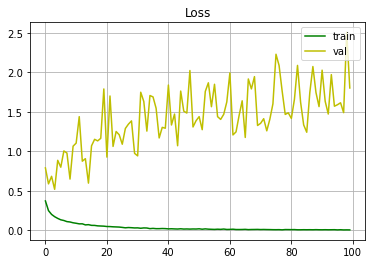

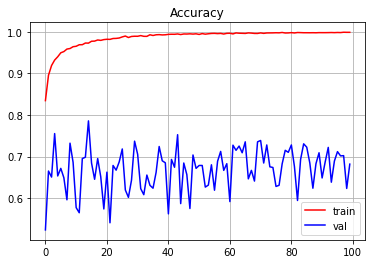

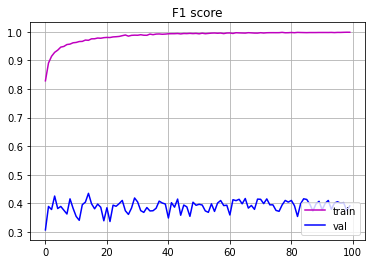

Done!


In [16]:
plot_loss_accu(model.history)
plot_loss(model.history)
plot_f1(model.history)
print("Done!")

In [17]:
#score = model.evaluate(x_val, y_val, verbose=1)
#print('Test loss:', score[0])
#print('Test accuracy:', score[1])

In [18]:
x_val.shape, y_val.shape

((1867, 256, 256, 3), (1867, 2))

In [19]:
from sklearn.metrics import f1_score
import numpy as np

def f1(y_true, y_pred):
	fsc = f1_score(y_true, y_pred, average='weighted')
	return round(fsc, 4)

def acc(y_true, y_pred):
	y_true = np.array(y_true)
	y_pred = np.array(y_pred)

	val = np.mean((y_true==y_pred))
	return round(val, 4)


In [20]:
# make predictions
y_pred = model.predict(x_val)
print(y_pred)
# get labels from predictions
pred_labels = np.array([np.argmax(pred) for pred in y_pred])
#convert ground truths to column values
y_val_flat = np.argmax(y_val, axis=1)
pred_labels.shape, y_val_flat.shape


[[2.5792373e-09 1.0000000e+00]
 [3.0737804e-10 1.0000000e+00]
 [2.4106668e-03 9.9758935e-01]
 ...
 [3.2083803e-01 6.7916197e-01]
 [7.2795230e-01 2.7204767e-01]
 [5.2641212e-07 9.9999952e-01]]


((1867,), (1867,))

In [21]:
y_true_flat = y_val_flat
y_pred_flat = pred_labels
y_true_flat.shape, y_pred_flat.shape

((1867,), (1867,))

In [22]:
print(y_true_flat)
print(y_pred_flat)
print(y_val_flat)

[1 1 1 ... 0 0 0]
[1 1 1 ... 1 0 1]
[1 1 1 ... 0 0 0]


In [23]:
metrics = {}

F1 = f1(y_val_flat, pred_labels) 
ACC = acc(y_val_flat, pred_labels)

metrics["Test F1"] = str(F1)
metrics["Test Accuracy"] = str(ACC)

print(F1, ACC)

0.6723 0.6818


In [24]:
with open('{}/test.txt'.format(EXP_PATH), 'w') as f:
    for k,v in metrics.items():
        f.write(str(k))
        f.write("--->")
        f.write(str(v))
        # new line
        f.write("\n")
f.close()

### Weighted

In [25]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_true_flat, y_pred_flat, average='weighted')

(0.669496804472463, 0.6818425281199786, 0.6723445803373145, None)

### Per label

In [26]:
precision_recall_fscore_support(y_true_flat, y_pred_flat, average=None, labels=[0, 1])

(array([0.55192308, 0.73199703]),
 array([0.44290123, 0.80885972]),
 array([0.49143836, 0.7685113 ]),
 array([ 648, 1219], dtype=int64))

### Confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_mtx = confusion_matrix(y_true_flat, y_pred_flat) 
print(confusion_mtx)

target_names = ['0', '1']
print(classification_report(y_true_flat, y_pred_flat, target_names=target_names))

[[287 361]
 [233 986]]
              precision    recall  f1-score   support

           0       0.55      0.44      0.49       648
           1       0.73      0.81      0.77      1219

    accuracy                           0.68      1867
   macro avg       0.64      0.63      0.63      1867
weighted avg       0.67      0.68      0.67      1867



In [31]:
"""plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('{}/{}_Class_mat.jpg'.format(EXP_PATH, EXP_NAME), dpi=300) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')"""

'plt.rcParams["axes.grid"] = False\nplt.rcParams.update({\'font.size\': 20})\n\nlabels = []\n\nlabel = test_generator.class_indices\nindexlabel = dict((value, key) for key, value in label.items())\n\nfor k,v in indexlabel.items():\n    labels.append(v)\n\nfrom sklearn.metrics import confusion_matrix\nimport itertools\ndef plot_confusion_matrix(cm, classes,\n                          normalize=False,\n                          title=\'Confusion matrix\',\n                          cmap=plt.cm.Blues):\n    accuracy = np.trace(cm) / float(np.sum(cm))\n    misclass = 1 - accuracy\n    if normalize:\n        cm = cm.astype(\'float\') / cm.sum(axis=1)[:, np.newaxis]\n        print("Normalized confusion matrix")\n    else:\n        print(\'Confusion Matrix\')\n\n    print(cm)\n#     fig = plt.figure()\n    plt.imshow(cm, interpolation=\'nearest\', cmap=cmap)\n#     plt.title(title)\n#     plt.colorbar()\n    tick_marks = np.arange(len(classes))\n    plt.xticks(tick_marks, classes, rotation=45

Confusion Matrix
[[287 361]
 [233 986]]


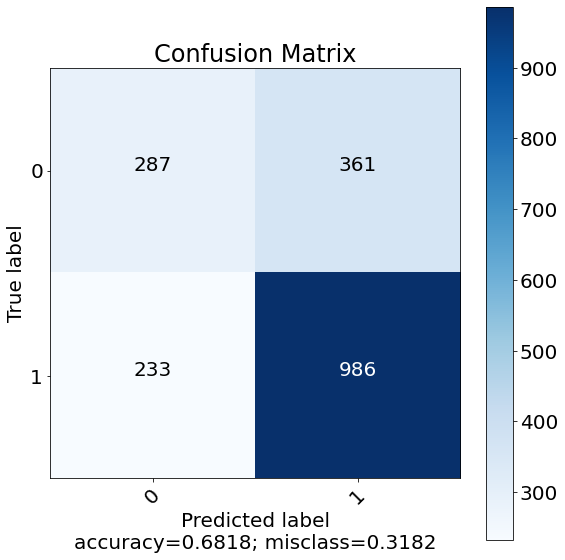

In [28]:
import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_flat,y_pred_flat)

labels = ['0', '1']
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(8,8))

# plot CF fancy image
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [29]:
print("Done!")

Done!
